# A notebook with the FRB/US model
This notebook is based on the the FRB/US model packages located here (https://www.federalreserve.gov/econres/us-models-package.htm).

This notebook and the tool used is highly experimental and the results are purely for illustration. 

You ca run each cell by pressing the run tool or shift+enter

# Import Python libraries

In [1]:
%matplotlib inline
import pandas as pd
import  ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pylab  as plt 
import seaborn as sns
import qgrid
from numba import jit

import sys
sys.path.append('modelflow/')

from modelsandbox import newmodel  
import modelnet as mn
import modelmf
from modelclass import ttimer


# Load the model and the data 
The model and the data has been prepared in a preprocessor step. 

In [2]:
turbo = 1   # Determines if the the model is compiled or not 

# define af function which is in Eviews but not in Python
@jit("f8(b1,f8,f8)")
def recode(condition,yes,no):
    '''Function which recratetes the functionality of @recode from eviews ''' 
    return yes if condition else no

basedf  = pd.read_pickle('data/baseline.pc')
ffrbus  = open('model/ffrbusvar.txt','rt').read()

# Create a model class instance

In [3]:
#define function which is used by FRB/US
@jit("f8(b1,f8,f8)")
def recode(condition,yes,no):
    '''Function which recratetes the functionality of @recode from eviews ''' 
    return yes if condition else no

mfrbus = newmodel(ffrbus,funks=[recode])
mfrbus.use_preorder = True 

This model has simultaneous elements or cyclical elements. The formulars will be evaluated in input sequence


# Show solving structure (only current year)

figsmall   = mn.draw_adjacency_matrix(mfrbus.endograph,mfrbus.precoreepiorder,
                                          mfrbus._superstrongblock,mfrbus._superstrongtype,size=(40,40))

mfrbus.drawendo(lag=0,title='FRB/US endogeneous interpendencies',pdf=1)

# How is the interest rate determined

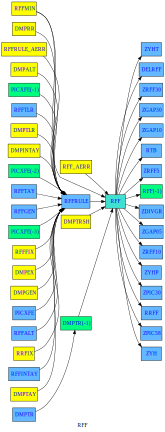

In [4]:
mfrbus.RFF.draw(up=2,down=1,HR=0,svg=1,pdf=1)

In [5]:
mfrbus.RFF

Endogeneous: RFF 
Formular: FRML  <> RFF=(1-DMPTRSH)*(RECODE((RFFRULE)>(RFFMIN),RFFRULE,RFFMIN))+DMPTRSH*(RECODE(((DMPTR(-1)*RFFRULE+(1-DMPTR(-1))*RFFMIN))>(RFFMIN),(DMPTR(-1)*RFFRULE+(1-DMPTR(-1))*RFFMIN),RFFMIN))+RFF_AERR  $

# Run Baseline

In [6]:
res = mfrbus(basedf,'2020q1','2025q4',antal= 500,relconv=0.000000001,
             conv='XGDPN',first_test=10,ldumpvar=True,ljit=0,silent=0,debug=0)

2020Q1 Solved in 11 iterations
2020Q2 Solved in 11 iterations
2020Q3 Solved in 11 iterations
2020Q4 Solved in 11 iterations
2021Q1 Solved in 11 iterations
2021Q2 Solved in 11 iterations
2021Q3 Solved in 11 iterations
2021Q4 Solved in 11 iterations
2022Q1 Solved in 11 iterations
2022Q2 Solved in 11 iterations
2022Q3 Solved in 11 iterations
2022Q4 Solved in 11 iterations
2023Q1 Solved in 11 iterations
2023Q2 Solved in 11 iterations
2023Q3 Solved in 11 iterations
2023Q4 Solved in 11 iterations
2024Q1 Solved in 11 iterations
2024Q2 Solved in 11 iterations
2024Q3 Solved in 11 iterations
2024Q4 Solved in 11 iterations
2025Q1 Solved in 11 iterations
2025Q2 Solved in 11 iterations
2025Q3 Solved in 11 iterations
2025Q4 Solved in 11 iterations
testmodel solved  


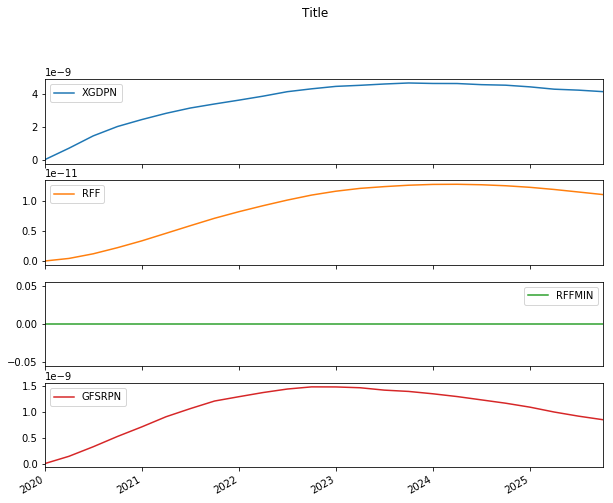

In [7]:
mfrbus.basedf = basedf
_ = mfrbus['XGDPN RFF RFFMIN GFSRPN'].dif.plot(colrow=1,sharey=0)

# Run alternative 

In [8]:
altdf = basedf.copy()
altdf=altdf.mfcalc('''\
rffintay_aerr = rffintay_aerr 
dmpex    = 0 
dmprr    = 0
dmptay   = 0
dmptlr   = 0 
dmpintay = 1
dmpalt   = 0
dmpgen   = 0

RFFMIN = 0.0
DMPTRSH = 0
'''.upper(),silent=1)
with ttimer('Solve Frbus'):
    res2 = mfrbus(altdf,'2020q1','2025q4',sim=True,antal= 500,relconv = 0.00000001,
                     conv='XGDPN',dumpvar ='rff*',first_test=10,ldumpvar=False,ljit=turbo,silent=1,debug=0)


Solve Frbus started at :        16:40:38 
Compiling chunk 0      16:40:39
Compiling a mastersolver      16:40:46
Compiling chunk 0      16:40:47
Compiling a mastersolver      16:41:00
Compiling chunk 0      16:41:01
Compiling a mastersolver      16:41:07
Solve Frbus took       :            29.1 Seconds


In [9]:
trans = {'XGDPN':'GDP real terms (XGDPN)','RFF':'Federal Funds Rate (RFF)','GFSRPN':'Federal Budget surplus',
        'RFFMIN':'Minimum Fed Funds'}


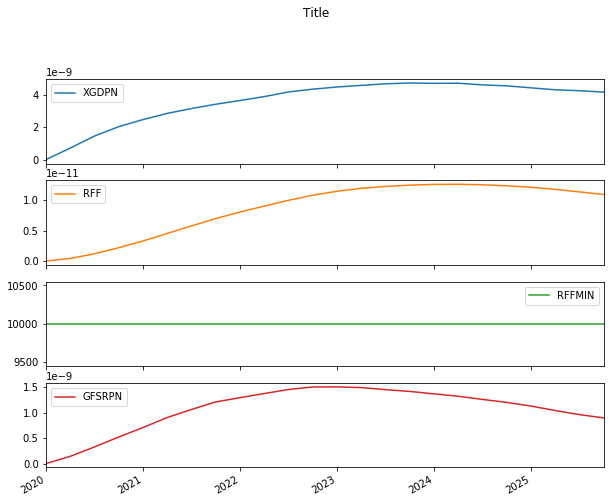

In [10]:
_ = mfrbus['XGDPN RFF RFFMIN GFSRPN'].dif.plot(colrow=1,sharey=0)

# Create interactive output widgets 
If you are not familiar with Python and Ipywidgets, don't try to understand the code. 
Just notice that it is fairly short. 

In [16]:
# Define output widget
def vis_alt3(dfs,model,title='Show variables'):
    ''' display tabbed widget with results from different dataframes, usuallly 2 but more can be shown'''
    avar = dfs[0].columns
    outlist =     [widgets.Output() for var in avar]
    outdiflist =     [widgets.Output() for var in avar]    
    deplist =     [widgets.Output() for var in avar]
    reslist =     [widgets.Output() for var in avar]
    attlist =     [widgets.Output() for var in avar]
    varouttablist =  [widgets.Tab(children = [out,outdif,att,dep,res]) 
                      for out,outdif,att,dep,res  in zip(outlist,outdiflist,attlist,deplist,reslist)]
    for var,varouttab in zip(avar,varouttablist):
        for i,tabtext in enumerate(['Level','Change','Attribution','Dependencies','Results']):
            varouttab.set_title(i,tabtext)

    controllist = [widgets.VBox([varouttab]) for varouttab in varouttablist]
    tab = widgets.Tab(children = controllist)
    for i,(var,out) in enumerate(zip(avar,controllist)):
        tab.set_title(i, var) 
    
    def test1(b):
        sel = b['new']
        out = outlist[sel]
        outdif = outdiflist[sel]
        dep = deplist[sel]
        res = reslist[sel]
        att = attlist[sel]
        var = avar[sel]
        with out:
            clear_output()
            fig,ax = plt.subplots(figsize=(10,6))
            ax.set_title(var,fontsize=14)
            for i,df in enumerate(dfs):
                data = df.loc[:,var]
                data.plot(ax=ax,legend=False,fontsize=14)
                x_pos = data.index[-1]
                if i == 0:
                    basevalue = data.values[-1]
                    ax.text(x_pos, data.values[-1],' Baseline',fontsize=14)
                else:
                    alt=i if len(dfs) >= 3 else ''
                    if abs(data.values[-1]/basevalue-1) > 0.01:
                        ax.text(x_pos, data.values[-1]  ,f' Alternative{alt}',fontsize=14)
                    else:
                        ax.text(x_pos, data.values[-1]  ,f'                and Alternative{alt}',fontsize=14)
            plt.show(fig)
        with outdif:
            clear_output()
            fig,ax = plt.subplots(figsize=(10,6))
            ax.set_title(var,fontsize=14)
            for i,df in enumerate(dfs):
                if i == 0:
                    basedata = df.loc[:,var]
                    x_pos = data.index[-1]
            else:
                data = df.loc[:,var]-basedata
                data.plot(ax=ax,legend=False,fontsize=14)
                x_pos = data.index[-1]
                alt=i if len(dfs) >= 3 else ''
                if abs(data.values[-1]/basevalue-1) > 0.01:
                    ax.text(x_pos, data.values[-1]  ,f' Alternative{alt}',fontsize=14)
                else:
                    ax.text(x_pos, data.values[-1]  ,f'                and Alternative{alt}',fontsize=14)
            plt.show(fig)
        with dep:
            clear_output()
            model.draw(var,up=2,down=2,svg=1)
        with res:
            clear_output()
            print(model.get_values(var).T)
        with att:
            clear_output()
            old = model.current_per
            #model.smpl(N-20,N)
            print('What explains the difference between the baseline and the alternative run ')
            print(model.allvar[var]['frml'])
            model.explain(var,up=0,dec=1,size=(9,12),svg=1,HR=0)
            model.current_per = old
            
    display(tab) 

    test1({'new':0})
    tab.observe(test1,'selected_index')
    return tab

# Define data extraction
def get_alt(mmodel,pat):
    ''' Retrieves variables matching pat from a model '''
    varnames = mmodel.vlist(pat)
    per = mmodel.current_per
    return [mmodel.basedf.loc[per,varnames],mmodel.lastdf.loc[per,varnames]]

a = vis_alt3(get_alt(mfrbus,['RFF XGDPN RFFMIN GFSRPN']),mfrbus)


# Create interactive input widget

In [34]:
# Define the imput widget 
def inputwidget(model,df,wdef,radiodef,varpat='RFF XGDPN RFFMIN GFSRPN DMPTRSH XXIBDUMMY',showout=1):
    '''Creates an input widgets for updating variables 
    
    :df: Baseline dataframe 
    :wdef: dict with definition of variables to be updated by slider
    :radiodef: dict of dic. each at first level defines a collection of radiobuttoms
               second level defines the text for each leved and the variable to set or reset to 0
    :varpat: the variables to show in the output widget
    :showout: 1 if the output widget is to be called '''
    
    wradiolist = [widgets.RadioButtons(options=cont['options'],description=des,layout={'width':'70%'},
                                       style={'description_width':'37%'}) for des,cont in radiodef.items()]
    # out = widgets.Output()
    def oradio(b):
        '''Set all radio variables to 0, and the selected variables to 1. '''
        from_radio  = b['owner'].description
        button_index = b['new']
        mulstart.loc[:,radiodef[from_radio]['vars'][button_index]] = 1 # to make sure it existe 
        mulstart.loc[:,radiodef[from_radio]['vars']] = 0  
        mulstart.loc[:,radiodef[from_radio]['vars'][button_index]] = 1 
        print(        mulstart.loc[:,radiodef[from_radio]['vars']])
            
        
    for i,des in enumerate(radiodef.keys()):
        wradiolist[i].observe(oradio,'index')
    if len(wradiolist) <=2:
        wradio = widgets.HBox(wradiolist)
    else: 
        wradio = widgets.VBox(wradiolist)

            
    wexp  = widgets.Label(value="Input new parameter ",layout={'width':'41%'})
    walt  =  widgets.Label(value="Alternative",layout={'width':'8%'})
    wbas  =  widgets.Label(value="Baseline",layout={'width':'8%'})
    whead = widgets.HBox([wexp,walt,wbas])
    
    wset  = [widgets.FloatSlider(description=var,min=min,max=max,value=value,step=0.01,
                                layout={'width':'50%'},style={'description_width':'30%'})
             for var,(value,min,max) in wdef.items()]
    waltval= [widgets.Label(value=f"{wdef[var][0]:>.2f}",layout={'width':'8%'})
              for var,(value,min,max)  in wdef.items()]
    wline = [widgets.HBox([s,v]) for s,v in zip(wset,waltval)]
    
    wgo   = widgets.Button(description="Run")
    wreset   = widgets.Button(description="Reset to default")
    wbut  = widgets.HBox([wgo,wreset])
    w     = widgets.VBox([whead]+wline+[wradio]+[wbut])

    # This function is run when the button is clecked 
    def run(b):
        mulstart       = df.copy()
        if 1:
            for i,var in enumerate(wdef.keys()):
                avar = var+'_AERR'
                if avar in mulstart.columns:
                    mulstart.loc[model.current_per,avar] =  mulstart.loc[model.current_per,avar] + wset[i].value
                else:    
                    mulstart.loc[model.current_per,var] =   wset[i].value

        #with out:
        clear_output()
        mul = model(mulstart,'2020q1','2025q4',sim=True,antal= 500,relconv = 0.00000001,
             conv='XGDPN',dumpvar ='rff*',first_test=10,ldumpvar=False,ljit=turbo,silent=0,debug=0)

        clear_output()
        display(w)
        #_ = mfrbus['XGDPN RFF RFFMIN GFSRPN'].dif.rename(trans).plot(colrow=1,sharey=0)
        if showout:
            a = vis_alt3(get_alt(model,varpat),model)

    def reset(b):
        for i,var in enumerate(wdef.keys()):
            wset[i].value  =   wdef[var][0]


    # Assign the function to the button  
    wgo.on_click(run)
    wreset.on_click(reset)
    out = widgets.Output()
    
    return w


wdef={'RFFINTAY':[0.0,-3,3],'RFFMIN':[0.0,-20,5]}
radiodef = {'Monetary policy reaction':{
            'options'  :['Inertial Taylor rule','Taylor rule','Taylor rule with unemployment gap','Estimated rule','Generalized rule','Exogenous nominal funds rate','Exogenous real funds rate'],
            'vars'     :['DMPINTAY',            'DMPTAY','DMPTLR'                               , 'DMPALT',        'DMPGEN',          'DMPEX',                        'DMPRR']
}}
           
r2 =       {'Timing of zero lower bound':{
             'options'  : ['Yes','No'],
             'vars'     : ['DMPTRSH','xxIBDUMMY'] 
           }}

display(inputwidget(mfrbus,basedf,wdef=wdef,radiodef={**radiodef,**r2}),showout=False)  

NameError: name 'mulstart' is not defined

In [29]:
mfrbus.DMPTRSH

Exogeneous : DMPTRSH 
 Values : 
      2020Q1  2020Q2  2020Q3  2020Q4  2021Q1  2021Q2  2021Q3  2021Q4  2022Q1  \
Base     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
Last     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
Diff     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

      2022Q2  ...  2023Q3  2023Q4  2024Q1  2024Q2  2024Q3  2024Q4  2025Q1  \
Base     1.0  ...     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
Last     1.0  ...     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
Diff     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

      2025Q2  2025Q3  2025Q4  
Base     1.0     1.0     1.0  
Last     1.0     1.0     1.0  
Diff     0.0     0.0     0.0  

[3 rows x 24 columns]

In [30]:
radiodef

{'Monetary policy reaction': {'options': ['Inertial Taylor rule',
   'Taylor rule',
   'Taylor rule with unemployment gap',
   'Estimated rule',
   'Generalized rule',
   'Exogenous nominal funds rate',
   'Exogenous real funds rate'],
  'vars': ['DMPINTAY',
   'DMPTAY',
   'DMPTLR',
   'DMPALT',
   'DMPGEN',
   'DMPEX',
   'DMPRR']}}

In [38]:
c = widgets.RadioButtons(options=['a','b'])
display(c)

RadioButtons(options=('a', 'b'), value='a')

In [40]:
c.value

'b'

In [42]:
c.index

0